# Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import random

import seaborn as sns
import matplotlib.pyplot as plt

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from optimization import functions
from optimization.updater import Updater

from utils import constants, common
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from models.policy_model import RobotPolicy
from models.reward_model import RewardFunction

# Constants

In [2]:
D_demo, D_samp = np.array([]), np.array([])
mean_loss_reward, mean_loss_policy = [], []

EPISODES_TO_PLAY = 10
REWARD_FUNCTION_UPDATE = 5
DEMO_BATCH = 256
NUM_EPOCHS = 500

# Define initial state means and variances
initial_state_means = [0.175, 0.5, 0.3]
initial_state_variances = [0.075, 0.05, 0.1]

# Define specific ranges for squashing
min_ranges = [0.10, 0.45, 0.20]
max_ranges = [0.25, 0.55, 0.40]

In [3]:
pd.set_option("display.max_columns", None)

current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
grand_parent_path = os.path.dirname(parent_path)

results_path = os.path.join(grand_parent_path, "results")

In [4]:
configs = Config()
# call the parameters method to set the parameters
configs.parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training Device: ", device)
configs.device = device

configs = functions.setup_config(device=device)

random.seed(configs.seed)
np.random.seed(configs.seed)
torch.manual_seed(configs.seed)

Current Time:  Feb_13_2024-14_41_48
Training Device:  cpu
Current Time:  Feb_13_2024-14_41_48


In [5]:
policy_saving_path, reward_saving_path = functions.create_directories(configs=configs,
                                                                      results_path=results_path,
                                                                      saving_policy=True,
                                                                      saving_reward=True)

json_paths_train, results_path = functions.get_directories(parent_directory=parent_directory,
                                                           data_folder_name=constants.DEMO_COLLECTION_DATE) # DEMO_COLLECTION_DATE, TEST_COLLECTION_DATE

In [6]:
training_data = PolicyDatasetLoader(demo_data_json_paths=json_paths_train)

train_loader = torch.utils.data.DataLoader(training_data,
                                           batch_size=configs.batch_size,
                                           shuffle=configs.data_shuffle,
                                           num_workers=configs.num_workers)

trajectory_indices = functions.find_indices_of_trajectory_changes(dataset=training_data)

policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)
reward_network = RewardFunction(state_action_size=configs.state_action_size,
                                hidden_size=configs.hidden_size,
                                out_size=configs.reward_size,
                                device=configs.device)

updater_obj = Updater(configs=configs,
                      policy_network=policy_network,
                      reward_network=reward_network)
updater_obj.initialize_optimizers()


================== Policy Dataset Loader ==================

Number of Trajectories:  43
Each Trajectory Length:  8
Full Demo Dataset Size:  333


# Functions

In [7]:
def preprocess_traj(traj_list_, step_list, is_Demo=False):
    step_list = step_list.tolist()
    
    for traj_df in traj_list_:
        
        if is_Demo:
            states = traj_df[["state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values
            actions = traj_df[["action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values
            probs = np.ones((actions.shape[0], actions.shape[1]))
        
        else:
            states = np.array([state_tensor[0].detach().numpy() for state_tensor in traj_df[0]])
            actions = np.array([action_tensor.clone().detach()[0].numpy() for action_tensor in traj_df[1]])
            probs = np.array([prob_tensor.clone().detach()[0].numpy() for prob_tensor in traj_df[2]])
        
        x = np.concatenate((states, probs, actions), axis=1)
        step_list.extend(x)
    
    return np.array(step_list)


def squash_fun(x, min_value, max_value):
    return 0.5 * (x + 1) * (max_value - min_value) + min_value


def generate_initial_rand_state(how_many=1):
    # Generate random samples for the initial state
    state_0_rand = np.random.normal(loc=initial_state_means,
                                    scale=np.sqrt(initial_state_variances),
                                    size=(how_many, len(initial_state_means)))

    # Squash the random samples to the specified ranges
    state_0_squashed = np.zeros_like(state_0_rand)
    for i in range(len(initial_state_means)):
        state_0_squashed[:, i] = squash_fun(x=state_0_rand[:, i], min_value=min_ranges[i], max_value=max_ranges[i])

    return state_0_squashed


def get_cumulative_rewards(rewards, gamma=0.99):
    G = torch.zeros_like(rewards, dtype=torch.float64)

    G[-1] = rewards[-1]

    for idx in range(len(rewards) - 2, -1, -1):
        G[idx] = rewards[idx] + gamma * G[idx + 1]

    return G


def policy_gradient_loss(cumulative_log_probs, advantages, entropy_weight=1e-2):
    weighted_log_probs = cumulative_log_probs * advantages
    
    entropy = -torch.mean(torch.sum(torch.exp(cumulative_log_probs) * cumulative_log_probs, dim=-1))
    
    loss = - torch.mean(weighted_log_probs) + entropy_weight * entropy

    return loss


def generate_session(t_max, updater_obj):
    states, traj_probs, actions, rewards = [], [], [], []
    
    state_0 = generate_initial_rand_state(how_many=1)
    s = torch.Tensor(state_0)

    for t in range(t_max):
        output_action_norm, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = \
            updater_obj.policy_network.estimate_action(state=s,
                                                       is_inference=False)
        a = output_action_norm

        action_probs = torch.exp(action_log_prob)

        output_action_denorm = common.denormalize_action(action_norm=output_action_norm.clone().detach().numpy(),
                                                         norm_range_list=training_data.action_norms)
        if output_action_denorm[0][-1] < -constants.ROBOT_BASE_HEIGHT:
            done = True
        else:
            done = False
        
#         norm_state_estim_df = pd.DataFrame(s)
#         state_estim_tensor = torch.tensor(norm_state_estim_df.values.astype(np.float64),
#                                           dtype=torch.float64,
#                                           device=configs.device)
        
        reward_values_tensor = updater_obj.reward_network.estimate_reward(state_action=s,
                                                                          is_inference=True)
        r = reward_values_tensor

        next_state_denorm = functions.calculate_next_state(action_denorm=output_action_denorm[0],
                                                           obstacle_location=np.array(constants.OBSTACLE_LOCATION),
                                                           target_location=np.array(constants.TARGET_LOCATION))
        new_s = common.normalize_state(state=next_state_denorm,
                                       norm_value_list=training_data.state_norms)
        
        states.append(s.clone().requires_grad_(True))
        traj_probs.append(action_probs.clone().requires_grad_(True))
        actions.append(a.clone().requires_grad_(True))
        rewards.append(r.clone().requires_grad_(True))
        
        s = torch.Tensor(np.array([new_s]))
        
        if done:
            print("DONE")
            break
    
    return states, actions, traj_probs, rewards

# Random State Range

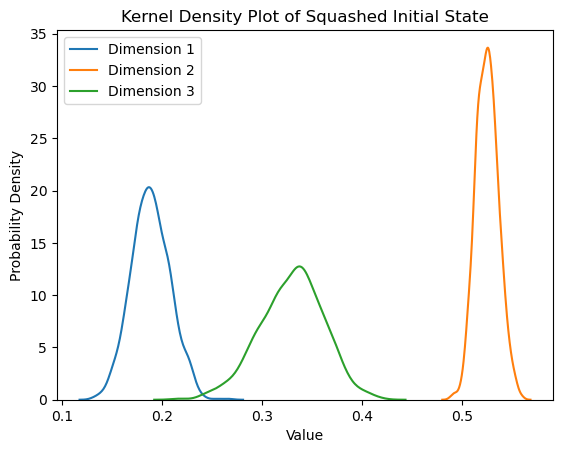

In [8]:
squashed_state_0 = generate_initial_rand_state(how_many=1000)

# Plot the squashed values
for i in range(len(initial_state_means)):
    sns.kdeplot(squashed_state_0[:, i], label=f'Dimension {i + 1}')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Kernel Density Plot of Squashed Initial State')

# Show the legend
plt.legend()

# Show the plot
plt.show()

# Tests

In [9]:
demo_traj_list = []

for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=False,
                                        is_inference_policy=False)
    demo_traj_list.append(traj_df)
    del traj_df

D_demo = preprocess_traj(traj_list_=demo_traj_list,
                         step_list=D_demo,
                         is_Demo=True)

In [10]:
states, actions, traj_probs, rewards = generate_session(t_max=5,
                                                        updater_obj=updater_obj)

In [11]:
states

[tensor([[0.1967, 0.5289, 0.3490]], requires_grad=True),
 tensor([[0.7842, 0.6097, 0.1001]], requires_grad=True),
 tensor([[0.3694, 0.5897, 0.3024]], requires_grad=True),
 tensor([[0.7569, 0.7705, 0.6316]], requires_grad=True),
 tensor([[0.7842, 0.9696, 0.2929]], requires_grad=True)]

In [12]:
actions

[tensor([[ 0.6026,  0.8337, -0.8681]], grad_fn=<CloneBackward0>),
 tensor([[-0.7279, -0.1409, -0.2614]], grad_fn=<CloneBackward0>),
 tensor([[-0.6265,  0.8738,  0.7263]], grad_fn=<CloneBackward0>),
 tensor([[ 0.8270, -0.5681, -0.2898]], grad_fn=<CloneBackward0>),
 tensor([[-0.5431,  0.1126, -0.3763]], grad_fn=<CloneBackward0>)]

In [13]:
traj_probs

[tensor([[0.3133, 0.2903, 0.2336]], grad_fn=<CloneBackward0>),
 tensor([[0.3360, 0.3989, 0.3452]], grad_fn=<CloneBackward0>),
 tensor([[0.3467, 0.2780, 0.3716]], grad_fn=<CloneBackward0>),
 tensor([[0.2344, 0.3510, 0.3250]], grad_fn=<CloneBackward0>),
 tensor([[0.3711, 0.4212, 0.3080]], grad_fn=<CloneBackward0>)]

In [14]:
rewards

[tensor([[0.5343]], requires_grad=True),
 tensor([[0.5357]], requires_grad=True),
 tensor([[0.5332]], requires_grad=True),
 tensor([[0.5335]], requires_grad=True),
 tensor([[0.5334]], requires_grad=True)]

# Reward Optimization

In [15]:
all_policy_loss = []
mean_reward_value = []

for i in range(NUM_EPOCHS):
    
    t_max = constants.TRAJECTORY_SIZE
    samp_trajs = [generate_session(t_max=t_max,
                                   updater_obj=updater_obj) for _ in range(EPISODES_TO_PLAY)]
    
    D_samp = preprocess_traj(traj_list_=samp_trajs,
                             step_list=D_samp,
                             is_Demo=False)
    
    loss_reward, loss_policy = [], []
    samp_reward_values = []
    is_early_stop = False
    
    for _ in range(REWARD_FUNCTION_UPDATE):
        selected_samp = np.random.choice(len(D_samp), DEMO_BATCH)
        selected_demo = np.random.choice(len(D_demo), DEMO_BATCH)
        
        D_s_samp = D_samp[selected_samp]
        D_s_demo = D_demo[selected_demo]
        
        D_s_samp = np.concatenate((D_s_demo, D_s_samp), axis=0)
        
        states_robot, probs_robot, actions_robot = D_s_samp[:,:3], D_s_samp[:,3:6], D_s_samp[:,6:9]
        states_expert, actions_expert = D_s_demo[:,:3], D_s_demo[:,6:9]
        
        states_robot = torch.tensor(states_robot, dtype=torch.float64).float()
        probs_robot = torch.tensor(probs_robot, dtype=torch.float64)
        action_probs_robot = torch.prod(probs_robot, dim=1).unsqueeze(1)
        actions_robot = torch.tensor(actions_robot, dtype=torch.float64)
        
        states_expert = torch.tensor(states_expert, dtype=torch.float64).float()
        actions_expert = torch.tensor(actions_expert, dtype=torch.float64)
        
        _, _, expert_action_log_prob, _, _, _ = \
            updater_obj.policy_network.estimate_action(state=states_expert,
                                                       is_inference=True)
        action_probs_demo = torch.prod(torch.exp(expert_action_log_prob), dim=1).unsqueeze(1)
        
        samp_rewards = updater_obj.reward_network.estimate_reward(state_action=states_robot, is_inference=False)
        demo_rewards = updater_obj.reward_network.estimate_reward(state_action=states_expert, is_inference=False)
        
        loss_IOC = -torch.mean(demo_rewards) + \
            torch.log(
                torch.mean(torch.exp(samp_rewards) / (action_probs_robot + 1e-7)))
        
        updater_obj.run_reward_optimizer(irl_loss=loss_IOC)
        loss_reward.append(loss_IOC.item())
        
        if torch.mean(demo_rewards) >= 0.99:
            is_early_stop = True
    
    for traj in samp_trajs:
        states, actions, traj_probs, rewards = traj
        
        states_ = torch.cat(states, dim=0)
        actions_ = torch.stack(actions).squeeze(1).requires_grad_(True)
        traj_probs_ = torch.cat([prob.clone().detach().requires_grad_(True) for prob in traj_probs], dim=0)
        
        samp_rewards_ = updater_obj.reward_network.estimate_reward(state_action=states_, is_inference=True)
        cumulative_returns = get_cumulative_rewards(samp_rewards_, 0.99).to(torch.float32)

        action_probs = torch.prod(traj_probs_, dim=1).unsqueeze(1)
        action_log_probs = torch.log(action_probs)
        cumulative_log_probs = torch.cumsum(action_log_probs, dim=0)
        
        loss_POL = policy_gradient_loss(cumulative_log_probs=cumulative_log_probs,
                                        advantages=cumulative_returns)
        updater_obj.run_policy_optimizer(bc_loss=loss_POL)
        loss_policy.append(loss_POL.item())
        all_policy_loss.append(loss_POL.item())
        samp_reward_values.append(torch.mean(samp_rewards_).item())
    
    mean_loss_reward.append(np.mean(loss_reward))
    mean_loss_policy.append(np.mean(loss_policy))
    mean_reward_value.append(np.mean(samp_reward_values))
    
    if i % 10 == 0:
        print("Avg. Reward : ", torch.mean(samp_rewards_).item())
        functions.save_reward(epoch=i,
                              reward_network=updater_obj.reward_network,
                              saving_path=reward_saving_path,
                              loss_value_str=str(abs(np.mean(loss_reward))).replace(".", "_"))
        functions.save_policy(epoch=i,
                              policy_network=updater_obj.policy_network,
                              saving_path=policy_saving_path,
                              loss_value_str=str(abs(np.mean(loss_policy))).replace(".", "_"))
    
#     if is_early_stop:
#         break

Avg. Reward :  0.5302861332893372
Saved Reward Network Model: reward_network_epoch_1_loss_2_715348415484064.pt
Saved Policy Network Model: policy_network_epoch_1_loss_26_128419494628908.pt
Avg. Reward :  0.5031614899635315
Saved Reward Network Model: reward_network_epoch_11_loss_2_6454370012267576.pt
Saved Policy Network Model: policy_network_epoch_11_loss_24_121614837646483.pt
Avg. Reward :  0.47215408086776733
Saved Reward Network Model: reward_network_epoch_21_loss_2_636629783436443.pt
Saved Policy Network Model: policy_network_epoch_21_loss_21_926929092407228.pt
Avg. Reward :  0.4537508189678192
Saved Reward Network Model: reward_network_epoch_31_loss_2_5953457398846984.pt
Saved Policy Network Model: policy_network_epoch_31_loss_21_610144805908202.pt
Avg. Reward :  0.4335209131240845
Saved Reward Network Model: reward_network_epoch_41_loss_2_575850391034128.pt
Saved Policy Network Model: policy_network_epoch_41_loss_20_09871635437012.pt
Avg. Reward :  0.39060166478157043
Saved Rewa

Avg. Reward :  0.03833862021565437
Saved Reward Network Model: reward_network_epoch_431_loss_1_9231064975772345.pt
Saved Policy Network Model: policy_network_epoch_431_loss_0_4873349189758301.pt
Avg. Reward :  0.06440193951129913
Saved Reward Network Model: reward_network_epoch_441_loss_1_9082471068285425.pt
Saved Policy Network Model: policy_network_epoch_441_loss_1_0910366252064705.pt
Avg. Reward :  0.14451095461845398
Saved Reward Network Model: reward_network_epoch_451_loss_1_908962420776818.pt
Saved Policy Network Model: policy_network_epoch_451_loss_3_2306910812854768.pt
Avg. Reward :  0.13344593346118927
Saved Reward Network Model: reward_network_epoch_461_loss_1_8907050574995679.pt
Saved Policy Network Model: policy_network_epoch_461_loss_1_8154796816408634.pt
Avg. Reward :  0.07342272251844406
Saved Reward Network Model: reward_network_epoch_471_loss_1_9237274458100089.pt
Saved Policy Network Model: policy_network_epoch_471_loss_2_3238033443689345.pt
Avg. Reward :  0.051831793

In [16]:
demo_rewards

tensor([[0.7927],
        [0.7101],
        [0.9789],
        [0.9712],
        [0.8850],
        [0.9948],
        [0.9665],
        [0.9928],
        [0.8851],
        [0.9659],
        [0.9949],
        [0.9527],
        [0.7861],
        [0.9884],
        [0.9938],
        [0.9527],
        [0.4370],
        [0.9169],
        [0.9542],
        [0.4648],
        [0.9353],
        [0.9399],
        [0.9875],
        [0.9953],
        [0.9929],
        [0.9073],
        [0.9793],
        [0.9884],
        [0.9935],
        [0.9940],
        [0.9929],
        [0.9586],
        [0.9489],
        [0.9860],
        [0.9736],
        [0.9940],
        [0.9944],
        [0.9615],
        [0.9665],
        [0.2906],
        [0.9888],
        [0.5323],
        [0.4648],
        [0.9933],
        [0.9649],
        [0.9789],
        [0.9879],
        [0.2669],
        [0.9911],
        [0.9881],
        [0.9781],
        [0.9284],
        [0.8794],
        [0.9939],
        [0.9932],
        [0

mean reward loss:2.1044362124174096 loss: 1.8858228870429303
mean policy loss:7.009385442652554 loss: 0.24265730381011963


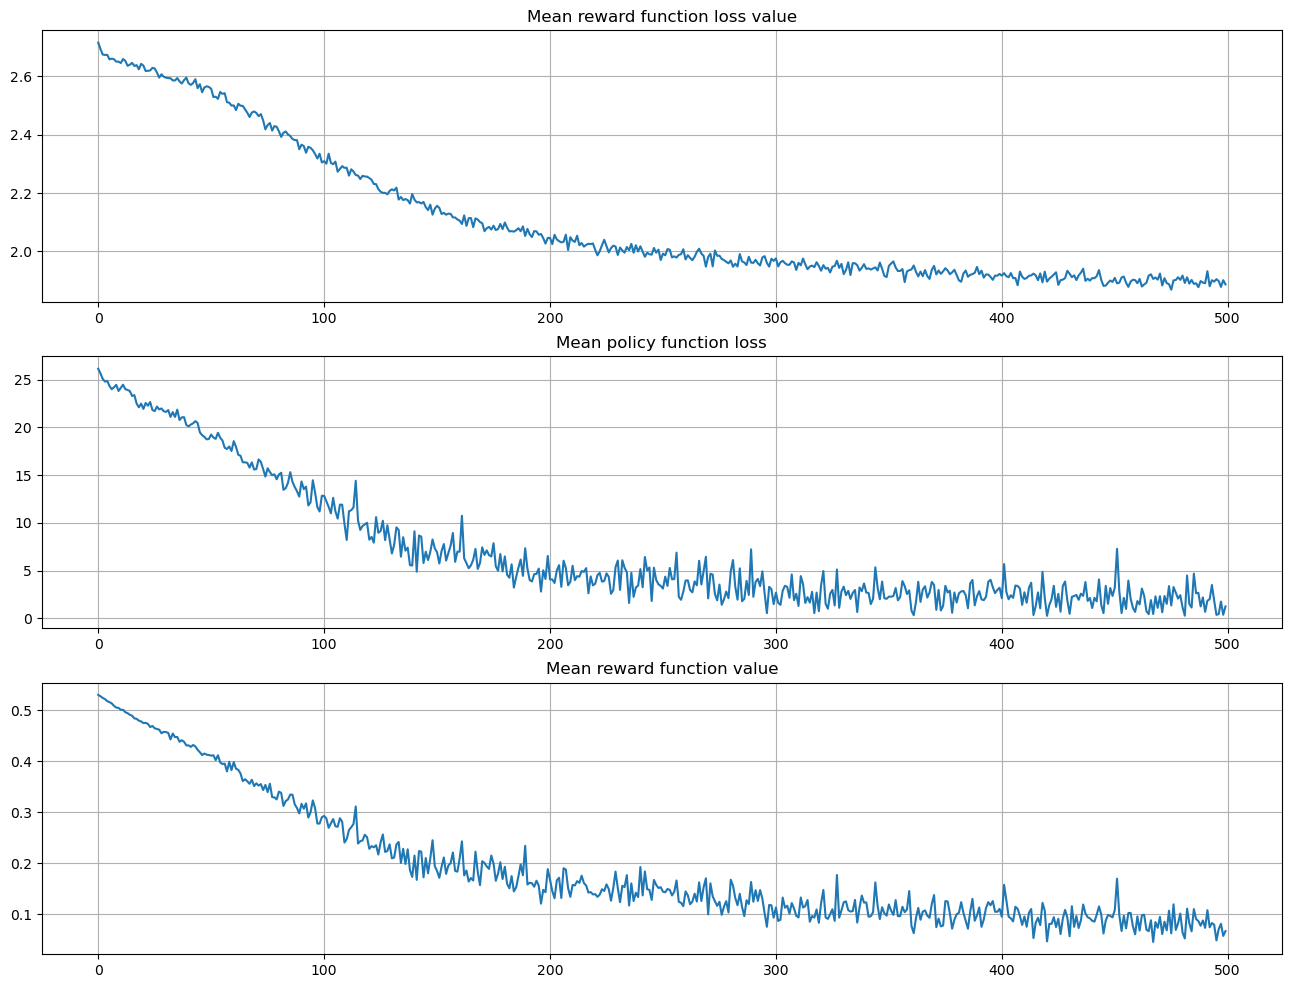

In [36]:
print(f"mean reward loss:{np.mean(mean_loss_reward)} loss: {loss_IOC.item()}")
print(f"mean policy loss:{np.mean(mean_loss_policy)} loss: {loss_POL.item()}")

plt.figure(figsize=[16, 12])
plt.subplot(3, 1, 1)
plt.title(f"Mean reward function loss value")
plt.plot(mean_loss_reward)
plt.grid()

plt.subplot(3, 1, 2)
plt.title(f"Mean policy function loss")
plt.plot(mean_loss_policy)
plt.grid()

plt.subplot(3, 1, 3)
plt.title(f"Mean reward function value")
plt.plot(mean_reward_value)
plt.grid()

plt.show()

# Evaluate Optimized Reward Function

In [18]:
test_trajectories = []

# loop through each separate trajectory inside the testing dataset
for traj_start_index in range(len(trajectory_indices)):
    
    traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
        functions.get_estimated_rewards(configs=configs,
                                        updater_obj=updater_obj,
                                        data_loader=training_data,
                                        policy_network=updater_obj.policy_network,
                                        reward_network=updater_obj.reward_network,
                                        trajectory_indices=trajectory_indices,
                                        traj_start_index=traj_start_index,
                                        is_inference_reward=True,
                                        is_inference_policy=True)
    
    # store outputs in the dataframe of trajectory information
    traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
    traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
    traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
    test_trajectories.append(traj_df)
    
    del traj_df

In [19]:
test_trajectories[-1]

,state_label_norm_1,state_label_norm_2,state_label_norm_3,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,action_label_norm_1,action_label_norm_2,action_label_norm_3,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_std_1,action_pred_std_2,action_pred_std_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,trajectory_index,state_number,gnll_loss,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,next_state_label_norm_1,next_state_label_norm_2,next_state_label_norm_3,next_state_label_denorm_1,next_state_label_denorm_2,next_state_label_denorm_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3,action_pred_avg_logprob,reward_demo_traj,reward_robot_traj
0,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,-0.366912245750,-0.261662185192,-0.432931691408,-0.733824491501,-0.523324370384,0.567068338394,-0.930947661400,-0.888378441334,-0.846567511559,-0.078880526125,0.030266061425,0.161170154810,1.012081503868,0.969902157784,0.930184662342,-0.157761096954,0.060532093048,1.161170125008,42,0,2.951235294342,0.239584520459,0.549098074436,0.238536208868,0.718753561378,1.647294223309,0.715608626604,0.206956240472,0.511369996287,0.245189446131,0.620868721416,1.534109988861,0.735568338394,0.218835143719,0.506871441759,0.443223375003,0.656505431158,1.520614325277,1.329670125008,-2.665893554688,0.267138391733,0.267138391733
1,0.206956237555,0.511370003223,0.245189443231,0.620868712664,1.534110009670,0.735568329692,-0.406059920788,-0.071958206594,-0.405145823956,-0.812119841576,-0.143916368484,0.594854176044,-0.917799293995,-0.907481610775,-0.855935752392,-0.103984825313,0.014572793618,0.181134685874,0.998861372471,0.988608479500,0.938938677311,-0.207969665527,0.029145479202,1.181134700775,42,1,2.959395885468,0.218835145235,0.506871461868,0.443223387003,0.656505435705,1.520614385605,1.329670161009,0.146144429566,0.424573652531,0.254451392015,0.438433288698,1.273720957594,0.763354176044,0.218841150211,0.515697205422,0.449878233592,0.656523450634,1.547091616267,1.349634700775,-2.681216716766,0.532716989517,0.112306818366
2,0.146144434810,0.424573659897,0.254451394081,0.438433304429,1.273720979691,0.763354182243,-0.395780444145,0.137874960899,-0.412418633699,-0.791560888290,0.275749921799,0.587581396103,-0.917791604996,-0.907328665257,-0.854998290539,-0.105191998184,0.015158458613,0.182948693633,0.998853683472,0.988457262516,0.938058733940,-0.210384011269,0.030316829681,1.182948708534,42,2,2.959288597107,0.218841150403,0.515697181225,0.449878245592,0.656523451209,1.547091543674,1.349634736776,0.160029739866,0.333697637197,0.252027132034,0.480089219599,1.001092911591,0.756081396103,0.219203054346,0.515959704320,0.450482902845,0.657609163038,1.547879112959,1.351448708534,-2.680118560791,0.925517559052,0.093558020890
3,0.160029739141,0.333697617054,0.252027124166,0.480089217424,1.001092851162,0.756081372499,-0.331732362509,0.288093000650,-0.496102273464,-0.663464784622,0.576185941696,0.503897726536,-0.917770624161,-0.907348275185,-0.854958295822,-0.105331808329,0.015107278712,0.183204829693,0.998832702637,0.988476693630,0.938021242619,-0.210663557053,0.030214548111,1.183204889297,42,3,2.969314098358,0.219203054905,0.515959680080,0.450482904911,0.657609164715,1.547879040241,1.351448714733,0.211847473945,0.254246920085,0.224132575512,0.635542421834,0.762740760254,0.672397726536,0.219256318865,0.516041556872,0.450568296432,0.657768956596,1.548124670616,1.351704889297,-2.680077075958,0.970557272434,0.092106044292
4,0.211847484112,0.254246890545,0.224132582545,0.635542452335,0.762740671635,0.672397747636,-0.250156402588,0.360676974058,-0.861667573452,-0.500312805176,0.721354007721,0.138332426548,-0.91

# Train Behavior Cloning Agent

In [20]:
updater_obj.policy_network = RobotPolicy(state_size=configs.state_size,
                                         hidden_size=configs.hidden_size,
                                         out_size=configs.action_size,
                                         log_std_min=configs.policy_log_std_min,
                                         log_std_max=configs.policy_log_std_max,
                                         log_std_init=configs.policy_log_std_init,
                                         device=configs.device)
updater_obj.policy_optimizer = torch.optim.Adam(updater_obj.policy_network.parameters(),
                                                lr=configs.policy_lr)

In [21]:
bc_training_epochs = 100

In [22]:
# lambda_pg = 1.0
# lambda_bc = 1.0

# mean_loss_bc, mean_loss_pg = [], []

# for epoch in range(bc_training_epochs):
    
#     bc_loss_list, pg_loss_list = [], []
    
#     for demo_traj_df in demo_traj_list:
        
#         states_demo = torch.Tensor(demo_traj_df[[
#             "state_label_norm_1", "state_label_norm_2", "state_label_norm_3"]].values.astype(np.float32), device=configs.device)
#         actions_demo = torch.Tensor(demo_traj_df[[
#             "action_label_norm_1", "action_label_norm_2", "action_label_norm_3"]].values.astype(np.float32), device=configs.device)
#         probs_demo = torch.Tensor(np.ones((
#             actions_demo.shape[0], actions_demo.shape[1])).astype(np.float32), device=configs.device)
        
#         demo_rewards_ = updater_obj.reward_network.estimate_reward(state_action=states_demo,
#                                                                    is_inference=True)
#         cumulative_returns = get_cumulative_rewards(demo_rewards_, 0.99).to(torch.float32)
        
# #         _, _, traj_log_probs, _, actions_pred_mu_std, _ = updater_obj.policy_network.estimate_action(state=states_demo,
# #                                                                                                  is_inference=False)
# #         cumulative_log_probs = torch.cumsum(traj_log_probs, dim=0)
        
# #         loss_pg_demo = policy_gradient_loss(cumulative_log_probs=cumulative_log_probs,
# #                                             advantages=cumulative_returns)
        
#         loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=actions_demo,
#                                                                   y_pred=actions_pred_mu_std)
        
# #         total_loss = (lambda_pg * loss_pg_demo) + (lambda_bc * loss_bc_traj)
        
#         updater_obj.run_policy_optimizer(bc_loss=loss_bc_traj)
        
#         bc_loss_list.append(loss_bc_traj.item())
# #         pg_loss_list.append(loss_pg_demo.item())
    
#     mean_loss_bc.append(np.mean(bc_loss_list))
# #     mean_loss_pg.append(np.mean(pg_loss_list))

#     print("Epoch : ", epoch, " Avg. BC Loss : ", np.mean(bc_loss_list), " Avg. PG Loss : ", np.mean(pg_loss_list))

In [23]:
for epoch in range(bc_training_epochs):
    
    # loop through each batch inside the dataset
    for batch_train_data in tqdm(train_loader):
        
        # get batch of data
        input_state, output_action, _, _ = functions.read_each_loader(configs=configs,
                                                                      sample_data=tuple(batch_train_data))
        
        # forward pass to get mean of Gaussian distribution
        action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = \
            policy_network.estimate_action(state=input_state,
                                           is_inference=False)
        
        # compute negative log-likelihood loss value for maximum likelihood estimation
        loss_bc_traj = updater_obj.multivariate_gaussian_nll_loss(y_true=output_action,
                                                                  y_pred=action_mu_and_std)
        batch_loss = loss_bc_traj.mean()
        
        updater_obj.run_policy_optimizer(bc_loss=loss_bc_traj)
        
        loss_value = round(batch_loss.item(), 5)
        loss_value_str = str(loss_value).replace(".", "_")
        
    print(f"Epoch {epoch + 1}/{bc_training_epochs}, Batch Loss: {loss_value}")

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.02it/s]


Epoch 1/100, Batch Loss: 3.09444


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.87it/s]


Epoch 2/100, Batch Loss: 3.09786


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.51it/s]


Epoch 3/100, Batch Loss: 3.12405


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.46it/s]


Epoch 4/100, Batch Loss: 3.06415


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.43it/s]


Epoch 5/100, Batch Loss: 3.11575


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.07it/s]


Epoch 6/100, Batch Loss: 3.12231


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.35it/s]


Epoch 7/100, Batch Loss: 3.04813


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.75it/s]


Epoch 8/100, Batch Loss: 3.14353


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.49it/s]


Epoch 9/100, Batch Loss: 3.05301


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.50it/s]


Epoch 10/100, Batch Loss: 3.11999


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.25it/s]


Epoch 11/100, Batch Loss: 3.13028


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.82it/s]


Epoch 12/100, Batch Loss: 3.10999


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.30it/s]


Epoch 13/100, Batch Loss: 3.13832


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.07it/s]


Epoch 14/100, Batch Loss: 3.06409


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.26it/s]


Epoch 15/100, Batch Loss: 3.07889


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.12it/s]


Epoch 16/100, Batch Loss: 3.10653


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.65it/s]


Epoch 17/100, Batch Loss: 3.07131


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.53it/s]


Epoch 18/100, Batch Loss: 3.11069


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.12it/s]


Epoch 19/100, Batch Loss: 3.09752


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.34it/s]


Epoch 20/100, Batch Loss: 3.09918


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.37it/s]


Epoch 21/100, Batch Loss: 3.08597


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.71it/s]


Epoch 22/100, Batch Loss: 3.06367


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.41it/s]


Epoch 23/100, Batch Loss: 3.0996


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.83it/s]


Epoch 24/100, Batch Loss: 3.09508


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.76it/s]


Epoch 25/100, Batch Loss: 3.09847


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.20it/s]


Epoch 26/100, Batch Loss: 3.1003


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.15it/s]


Epoch 27/100, Batch Loss: 3.07529


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.83it/s]


Epoch 28/100, Batch Loss: 3.04727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.46it/s]


Epoch 29/100, Batch Loss: 3.11837


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.21it/s]


Epoch 30/100, Batch Loss: 3.06381


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.12it/s]


Epoch 31/100, Batch Loss: 3.08727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 39.09it/s]


Epoch 32/100, Batch Loss: 3.07926


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.30it/s]


Epoch 33/100, Batch Loss: 3.05674


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.55it/s]


Epoch 34/100, Batch Loss: 3.06202


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.16it/s]


Epoch 35/100, Batch Loss: 3.12216


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.59it/s]


Epoch 36/100, Batch Loss: 3.12881


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.94it/s]


Epoch 37/100, Batch Loss: 3.12778


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.37it/s]


Epoch 38/100, Batch Loss: 3.07989


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.03it/s]


Epoch 39/100, Batch Loss: 3.08948


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.69it/s]


Epoch 40/100, Batch Loss: 3.05249


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.19it/s]


Epoch 41/100, Batch Loss: 3.081


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.10it/s]


Epoch 42/100, Batch Loss: 3.0688


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.27it/s]


Epoch 43/100, Batch Loss: 3.097


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.58it/s]


Epoch 44/100, Batch Loss: 3.12077


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.64it/s]


Epoch 45/100, Batch Loss: 3.05379


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.65it/s]


Epoch 46/100, Batch Loss: 3.09836


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.82it/s]


Epoch 47/100, Batch Loss: 3.06546


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.78it/s]


Epoch 48/100, Batch Loss: 3.08371


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.34it/s]


Epoch 49/100, Batch Loss: 3.12901


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.24it/s]


Epoch 50/100, Batch Loss: 3.06525


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.13it/s]


Epoch 51/100, Batch Loss: 3.09764


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.84it/s]


Epoch 52/100, Batch Loss: 3.08121


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.40it/s]


Epoch 53/100, Batch Loss: 3.06189


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.49it/s]


Epoch 54/100, Batch Loss: 3.09835


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.61it/s]


Epoch 55/100, Batch Loss: 3.06431


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.34it/s]


Epoch 56/100, Batch Loss: 3.05345


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.01it/s]


Epoch 57/100, Batch Loss: 3.09917


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.54it/s]


Epoch 58/100, Batch Loss: 3.10047


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.62it/s]


Epoch 59/100, Batch Loss: 3.0819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.04it/s]


Epoch 60/100, Batch Loss: 3.06601


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.69it/s]


Epoch 61/100, Batch Loss: 3.09592


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.14it/s]


Epoch 62/100, Batch Loss: 3.13312


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.33it/s]


Epoch 63/100, Batch Loss: 3.11023


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.92it/s]


Epoch 64/100, Batch Loss: 3.07558


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.38it/s]


Epoch 65/100, Batch Loss: 3.11436


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.34it/s]


Epoch 66/100, Batch Loss: 3.08909


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.32it/s]


Epoch 67/100, Batch Loss: 3.08211


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.38it/s]


Epoch 68/100, Batch Loss: 3.09946


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.09it/s]


Epoch 69/100, Batch Loss: 3.07385


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.80it/s]


Epoch 70/100, Batch Loss: 3.093


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.24it/s]


Epoch 71/100, Batch Loss: 3.08678


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.43it/s]


Epoch 72/100, Batch Loss: 3.08008


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.74it/s]


Epoch 73/100, Batch Loss: 3.10287


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.59it/s]


Epoch 74/100, Batch Loss: 3.08098


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.17it/s]


Epoch 75/100, Batch Loss: 3.11656


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.61it/s]


Epoch 76/100, Batch Loss: 3.10536


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.61it/s]


Epoch 77/100, Batch Loss: 3.04066


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.09it/s]


Epoch 78/100, Batch Loss: 3.10911


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.58it/s]


Epoch 79/100, Batch Loss: 3.08965


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.44it/s]


Epoch 80/100, Batch Loss: 3.08274


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.41it/s]


Epoch 81/100, Batch Loss: 3.05621


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.32it/s]


Epoch 82/100, Batch Loss: 3.07638


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.17it/s]


Epoch 83/100, Batch Loss: 3.09848


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.51it/s]


Epoch 84/100, Batch Loss: 3.08309


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.84it/s]


Epoch 85/100, Batch Loss: 3.06885


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.21it/s]


Epoch 86/100, Batch Loss: 3.09827


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.97it/s]


Epoch 87/100, Batch Loss: 3.08746


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.57it/s]


Epoch 88/100, Batch Loss: 3.05961


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.93it/s]


Epoch 89/100, Batch Loss: 3.06985


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.35it/s]


Epoch 90/100, Batch Loss: 3.07604


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.23it/s]


Epoch 91/100, Batch Loss: 3.09077


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.56it/s]


Epoch 92/100, Batch Loss: 3.08474


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.66it/s]


Epoch 93/100, Batch Loss: 3.05953


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.19it/s]


Epoch 94/100, Batch Loss: 3.07684


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.74it/s]


Epoch 95/100, Batch Loss: 3.06552


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.60it/s]


Epoch 96/100, Batch Loss: 3.07645


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 44.48it/s]


Epoch 97/100, Batch Loss: 3.12243


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 43.67it/s]


Epoch 98/100, Batch Loss: 3.10052


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 40.98it/s]


Epoch 99/100, Batch Loss: 3.09687


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.93it/s]

Epoch 100/100, Batch Loss: 3.0936


In [24]:
action_pred

tensor([[-0.8679, -0.7961, -0.4347],
        [-0.4226,  0.7860,  0.6861],
        [ 0.7589,  0.7822,  0.2804],
        [ 0.3342,  0.0031, -0.8683],
        [ 0.7567, -0.3043,  0.5662],
        [ 0.4417,  0.9912, -0.7483],
        [-0.3643,  0.9848,  0.6764],
        [-0.4028, -0.4145,  0.6598],
        [ 0.0969, -0.5801,  0.8074],
        [-0.9846, -0.2906,  0.0044],
        [-0.7168,  0.6970,  0.2005],
        [ 0.3917, -0.8583,  0.2793],
        [ 0.5351, -0.1582, -0.5679]], grad_fn=<TanhBackward0>)

In [25]:
action_mu_and_std

tensor([[-0.8679, -0.7961, -0.4347,  1.0036,  0.9912,  0.9817],
        [-0.4226,  0.7860,  0.6861,  1.0056,  0.9958,  0.9956],
        [ 0.7589,  0.7822,  0.2804,  1.0060,  0.9918,  0.9551],
        [ 0.3342,  0.0031, -0.8683,  1.0099,  0.9831,  0.9429],
        [ 0.7567, -0.3043,  0.5662,  1.0020,  0.9911,  0.9687],
        [ 0.4417,  0.9912, -0.7483,  0.9997,  0.9936,  0.9617],
        [-0.3643,  0.9848,  0.6764,  1.0015,  1.0031,  1.0126],
        [-0.4028, -0.4145,  0.6598,  1.0135,  0.9811,  0.9480],
        [ 0.0969, -0.5801,  0.8074,  1.0057,  0.9908,  0.9563],
        [-0.9846, -0.2906,  0.0044,  1.0092,  0.9852,  0.9456],
        [-0.7168,  0.6970,  0.2005,  1.0064,  0.9891,  0.9501],
        [ 0.3917, -0.8583,  0.2793,  1.0053,  0.9937,  0.9884],
        [ 0.5351, -0.1582, -0.5679,  1.0059,  0.9964,  0.9968]],
       grad_fn=<CatBackward0>)

# Generate Random Initial State Trajectories with Trained BC Policy

In [26]:
for param in updater_obj.policy_network.parameters():
    param.requires_grad = False
updater_obj.policy_network = updater_obj.policy_network.eval()

In [27]:
# bc_trajs = [generate_session(t_max=constants.TRAJECTORY_SIZE, updater_obj=updater_obj) for _ in range(5)]

In [28]:
state_0 = generate_initial_rand_state()
input_state_norm = torch.Tensor(state_0)
    
created_trajectory_df, logprob_action_sum_tensor, reward_values_tensor = \
    functions.trajectory_generation(configs=configs,
                                    state_norms=training_data.state_norms,
                                    action_norms=training_data.action_norms,
                                    policy_network=updater_obj.policy_network,
                                    reward_network=updater_obj.reward_network,
                                    input_state_norm=input_state_norm)

In [29]:
created_trajectory_df

,state_number,state_est_norm_1,state_est_norm_2,state_est_norm_3,state_est_denorm_1,state_est_denorm_2,state_est_denorm_3,action_pred_norm_1,action_pred_norm_2,action_pred_norm_3,action_pred_denorm_1,action_pred_denorm_2,action_pred_denorm_3,action_pred_logprob_1,action_pred_logprob_2,action_pred_logprob_3,next_state_est_norm_1,next_state_est_norm_2,next_state_est_norm_3,next_state_est_denorm_1,next_state_est_denorm_2,next_state_est_denorm_3
0,0,0.179816171527,0.516094446182,0.335611283779,0.539448514581,1.548283338547,1.006833851337,-0.034162975848,0.024130750448,-0.073407463729,-0.068325996399,0.048261404037,0.926592528820,-0.973102211952,-0.871624708176,-0.945504844189,0.167053551067,0.447860093724,0.365030842940,0.501160653201,1.343580281173,1.095092528820
1,1,0.167053550482,0.447860091925,0.365030854940,0.501160651445,1.343580275774,1.095092564821,-0.026187738404,0.030674453825,-0.074206098914,-0.052375435829,0.061348915100,0.925793886185,-0.958585500717,-0.882730364799,-0.948771893978,0.170892175493,0.446504739548,0.364764628728,0.512676526480,1.339514218645,1.094293886185
2,2,0.170892179012,0.446504741907,0.364764630795,0.512676537037,1.339514225721,1.094293892384,-0.026078887284,0.031496267766,-0.074214428663,-0.052157759666,0.062992572784,0.925785541534,-0.958188056946,-0.882431626320,-0.949751675129,0.171005775497,0.446229536535,0.364761847178,0.513017326491,1.338688609604,1.094285541534
3,3,0.171005770564,0.446229547262,0.364761859179,0.513017311692,1.338688641787,1.094285577536,-0.026055125520,0.031556405127,-0.074198842049,-0.052110195160,0.063112735748,0.925801157951,-0.958147644997,-0.882435560226,-0.949782788754,0.171025220616,0.446216285447,0.364767052650,0.513075661847,1.338648856340,1.094301157951
4,4,0.171025216579,0.446216285229,0.364767044783,0.513075649738,1.338648855686,1.094301134348,-0.026053803042,0.031562741846,-0.074199154973,-0.052107572556,0.063125371933,0.925800859928,-0.958144724369,-0.882434487343,-0.949787735939,0.171026259549,0.446214181099,0.364766953309,0.513078778647,1.338642543296,1.094300859928
5,5,0.171026259661,0.446214169264,0.364766955376,0.513078778982,1.338642507792,1.094300866127,-0.026053629816,0.031563233584,-0.074199005961,-0.052107214928,0.063126564026,0.925800979137,-0.958144545555,-0.882434487343,-0.949787974358,0.171026418063,0.446214031171,0.364766993046,0.513079254189,1.338642093514,1.094300979137
6,6,0.171026423573,0.446214020252,0.364766985178,0.513079270720,1.338642060757,1.094300955534,-0.026053598151,0.031563278288,-0.074198998511,-0.052107214928,0.063126564026,0.925800979137,-0.958144426346,-0.882434546947,-0.949788093567,0.171026418063,0.446214031171,0.364766993046,0.513079254189,1.338642093514,1.094300979137
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
reward_values_tensor

tensor([[0.4144],
        [0.6552],
        [0.6436],
        [0.6441],
        [0.6440],
        [0.6440],
        [0.6440],
        [   nan]])

# Evalutions

In [31]:
# test_bc_trajectories = []

# # loop through each separate trajectory inside the testing dataset
# for traj_start_index in range(len(trajectory_indices)):
    
#     traj_df, reward_values_demo_data, reward_values_estim_data, logprob_action_estim_avg = \
#         functions.get_estimated_rewards(configs=configs,
#                                         updater_obj=updater_obj,
#                                         data_loader=training_data,
#                                         policy_network=updater_obj.policy_network,
#                                         reward_network=updater_obj.reward_network,
#                                         trajectory_indices=trajectory_indices,
#                                         traj_start_index=traj_start_index,
#                                         is_inference_reward=True,
#                                         is_inference_policy=True)
    
#     # store outputs in the dataframe of trajectory information
#     traj_df[constants.ACTION_PREDICTION_AVG_LOGPROB_NAME] = logprob_action_estim_avg.numpy().flatten()
#     traj_df[constants.REWARD_DEMONSTRATION_TRAJECTORY_NAME] = reward_values_demo_data.numpy().flatten()
#     traj_df[constants.REWARD_ROBOT_TRAJECTORY_NAME] = reward_values_estim_data.numpy().flatten()
    
#     test_bc_trajectories.append(traj_df)
    
#     del traj_df

In [32]:
# test_bc_trajectories[-1]

In [33]:
maxi = 0.2

for traj in demo_traj_list:
    first = traj["state_label_norm_3"].iloc[0]
    
    if first > maxi:
        maxi = first

In [34]:
maxi

0.381481

In [35]:
traj["state_label_norm_1"]

0   0.239584520459
1   0.206956237555
2   0.146144434810
3   0.160029739141
4   0.211847484112
5   0.279522150755
6   0.275211930275
Name: state_label_norm_1, dtype: float32